In [1]:
import os
import torch
from d2l import torch as d2l

In [4]:
# 下载和预处理数据集
# 设置下载地址
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入“英语－法语”数据集。"""
    data_dir = d2l.download_extract('fra-eng')#从下载地址中下载，并返回保存文件的路径
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding="utf-8") as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [5]:
# 预处理
def preprocess_nmt(text):
    """预处理“英语－法语”数据集。"""
    def no_space(char, prev_char):
        """判断没有与文字间隔空格的标点"""
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]# 处理使得单词、符号之间都有空格隔开
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [6]:
# 词元化
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集。"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        # 拆分英语和法语两句话
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6] 

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

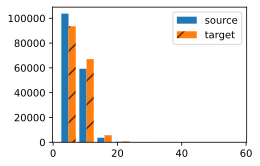

In [7]:
# 绘制每个文本序列所包含的标记数量的直方图
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [8]:
# 词汇表

src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [23]:
# src_vocab的使用

source[0], src_vocab[source[0]],src_vocab['<pad>']

(['go', '.'], [47, 4], 1)

In [24]:
# 序列样本都有一个固定的长度 截断或填充文本序列

def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列。"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

# 将文本索引序列长度控制为num_steps
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
# 转换成小批量数据集用于训练

def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量。"""
    lines = [vocab[l] for l in lines]#转化为文本索引
    lines = [l + [vocab['<eos>']] for l in lines]#每句添加结尾标识符索引
    array = torch.tensor([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])#每句话转化为一个tensor
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)#每句话的长度(除去标识符的长度)
    return array, valid_len

In [27]:
# 训练模型

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表。"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [29]:
# 读出“英语－法语”数据集中的第一个小批量数据

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))# 索引值为1的位置是填空的标识符
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[14, 27,  4,  3,  1,  1,  1,  1],
        [17, 20,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[ 20,  58,   5,   3,   1,   1,   1,   1],
        [ 11,  61, 145,   4,   3,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([4, 5])
